### makemore: part 5 

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [36]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [37]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [38]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [39]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [40]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [119]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / \
            fan_in**0.5  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


# ----------------------------------------------------------------------------------------------------------


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0 
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# ----------------------------------------------------------------------------------------------------------


class Tanh:
    def __call__(self, x):
        #         print('Tanh: __call_ ',x)
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return[]

# ----------------------------------------------------------------------------------------------------------


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# ----------------------------------------------------------------------------------------------------------


class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)  # '//' is integer division
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# ----------------------------------------------------------------------------------------------------------


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and srtech them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [120]:
torch.manual_seed(42); #seed rng for reproducibility

In [121]:
n_embd = 24 #the dimensionality of the character embeding vectors
n_hidden = 128 #200 the number of the neurons in the  hidden layer of the MLP 

C = torch.randn((vocab_size, n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])


#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1#last layer: make less confident # no Batchnorm used
    
parameters = model.parameters() 
print(sum(p.nelement() for p in parameters)) #number of parameters in total 
for p in parameters:
    p.requires_grad = True

76579


In [122]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [123]:
model.layers[3].running_mean.shape

torch.Size([128])

In [124]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = [] #ud in Andrej's code

for i in range(max_steps):
    
    #minibatch consrtuct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    #forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    

      0/ 200000: 3.2961
  10000/ 200000: 1.4403
  20000/ 200000: 1.9611
  30000/ 200000: 2.1270
  40000/ 200000: 1.6317
  50000/ 200000: 2.0897
  60000/ 200000: 1.8831
  70000/ 200000: 1.8088
  80000/ 200000: 2.0763
  90000/ 200000: 1.5201
 100000/ 200000: 1.8769
 110000/ 200000: 1.7806
 120000/ 200000: 2.2071
 130000/ 200000: 2.0102
 140000/ 200000: 1.8415
 150000/ 200000: 1.8067
 160000/ 200000: 1.4932
 170000/ 200000: 1.5981
 180000/ 200000: 1.5910
 190000/ 200000: 1.5078


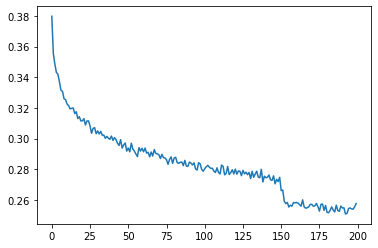

In [125]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [126]:
#put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [127]:
# evaluate the loss
torch.no_grad() #this decorator  disables gradient tracking inside pythorc
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7723850011825562
val 1.9874457120895386


#### Performance log
- original (3 chararcters context + 200 hidden neurons, 12k params): 
  -> train 2.058, val 2.105
- context  3 -> 8 charactrs 22k params: 
  -> train 1.91, val 2.03
- changed flat to hierarchical(22k params): 
  -> train 1.943 val 2.028 (A results)
- fixed bug in batchnorm regarding the dimensions 0 vs (0,1) : 
   -> rain 1.914 val 2.03
- scaled up the newtwork n_embed =24 and n_didden (neurons) = 128
   -> train 1.7723850011825562, val 1.9874457120895386

In [26]:
# sample  from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all...
    
    while True: 
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift he context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

volton.
coril.
jelonie.
ochsida.
kayvan.
anya.
perstika.
malailah.
isair.
jaxseen.
ahmhia.
prak.
lodyxrid.
merrose.
jotty.
demalyse.
juliana.
thrkira.
raithet.
auliyah.
